In [21]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from grating import *

In [10]:
%config IPCompleter.use_jedi = False

In [11]:
epsilon_Si = 13.491
epsilon_SiO2 = 2.085136
n_freqs = 200
freqs = np.linspace(0.15, 0.25, n_freqs)
n_grating_layers = 15

In [12]:
fname = 'dataset.npz'
with np.load(fname) as data:
    designs = data['D']
    responses = data['R']
    
n_grating_layers = designs.shape[-1]
n_freqs = responses.shape[-1]
Dtrain, Dtest, Rtrain, Rtest = train_test_split(designs, responses,
                                                test_size=0.1,
                                                random_state=42)
print("Train set contains {} samples".format(Dtrain.shape[0]))
print("Validation set contains {} samples".format(Dtest.shape[0]))

Train set contains 588429 samples
Validation set contains 65381 samples


In [45]:
load_dir = 'forward_model'
fmodel = keras.models.load_model(
    os.path.join(load_dir, 'Arch4_Epochs400_Adam0001_Sigmoid.h5'))

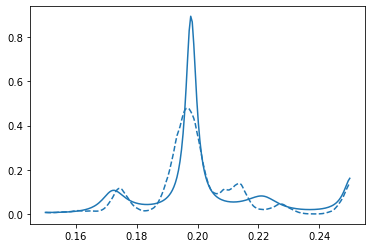

In [47]:
np.random.seed(42)
D = np.random.random_sample((1, n_grating_layers))
gr = Grating(epsilon_Si, epsilon_SiO2, D[0])
fig, ax = plt.subplots()
line, = ax.plot(freqs, gr.transmittivity(freqs))
ax.plot(freqs, fmodel(D)[0].numpy(), '--', color=line.get_color())

In [100]:
activation = keras.activations.sigmoid
inputs = layers.Input((n_freqs,), name='D')
I1 = layers.Dense(500, activation=activation, name='I1')
I2 = layers.Dense(200, activation=activation, name='I2')
I3 = layers.Dense(n_grating_layers, activation='relu', name='I3')
imodel = keras.Sequential([inputs, I1, I2, I3])
imodel.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
I1 (Dense)                   (None, 500)               100500    
_________________________________________________________________
I2 (Dense)                   (None, 200)               100200    
_________________________________________________________________
I3 (Dense)                   (None, 15)                3015      
Total params: 203,715
Trainable params: 203,715
Non-trainable params: 0
_________________________________________________________________


In [102]:
tandem = keras.Model(input_layer, fmodel(imodel(inputs)))
tandem.layers[-1].trainable = False
tandem.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
D (InputLayer)               [(None, 200)]             0         
_________________________________________________________________
sequential_18 (Sequential)   (None, 15)                203715    
_________________________________________________________________
sequential_4 (Sequential)    (None, 200)               228800    
Total params: 432,515
Trainable params: 203,715
Non-trainable params: 228,800
_________________________________________________________________


In [103]:
def loss(y_true, y_pred):
    return n_freqs * keras.losses.mse(y_true, y_pred)

tandem.compile(loss=loss, optimizer='adam')

In [105]:
info = tandem.fit(Rtrain, Rtrain,
                 batch_size=128, epochs=10,
                 validation_data=(Rtest, Rtest),
                 validation_freq=1,
                 initial_epoch=initial_epoch)
initial_epoch = info.epoch[-1]

Epoch 1/10
4598/4598 [==============================] - 26s 6ms/step - loss: 7.4798 - val_loss: 7.0249
Epoch 2/10
4598/4598 [==============================] - 33s 7ms/step - loss: 6.6164 - val_loss: 5.8194
Epoch 3/10
4598/4598 [==============================] - 44s 10ms/step - loss: 5.6502 - val_loss: 5.4351
Epoch 4/10
4598/4598 [==============================] - 43s 9ms/step - loss: 5.3250 - val_loss: 5.3145
Epoch 5/10
4598/4598 [==============================] - 42s 9ms/step - loss: 5.1476 - val_loss: 5.1017
Epoch 6/10
4598/4598 [==============================] - 40s 9ms/step - loss: 5.0373 - val_loss: 4.9494
Epoch 7/10
4598/4598 [==============================] - 39s 8ms/step - loss: 4.9526 - val_loss: 4.8931
Epoch 8/10
4598/4598 [==============================] - 50s 11ms/step - loss: 4.8793 - val_loss: 4.8895
Epoch 9/10
4598/4598 [==============================] - 70s 15ms/step - loss: 4.7528 - val_loss: 4.5469
Epoch 10/10
4598/4598 [==============================] - 79s 17ms/step

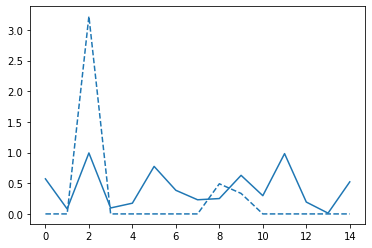

In [106]:
idx = np.random.randint(0, Rtest.shape[0], 1)
dnn_designs = imodel(Rtest[idx]).numpy()
true_designs = Dtest[idx]
for o, r in zip(dnn_designs, true_designs):
    line, = plt.plot(o, '--')
    plt.plot(r, '-', color=line.get_color())